Tujuan: memprediksi `case` dan `unit_cost` bulanan

Notebook ini digunakan untuk eksplorasi dan validasi untuk pengembangan model

In [1]:
import os
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import random
import warnings
warnings.filterwarnings('ignore')

from src.features import generate_date_features, get_cross_tkp_metrics, generate_lag_features
from src.util import seed_everything, mae, mape, read_data, create_folds
pd.set_option('display.max_columns', 200)

Let's create a utility functions first

In [3]:
# Default parameters
TARGET = ['case', 'unit_cost']
SEED = 2021
categorical_features = [
    'kddati2',
    'tkp',
    'id',
    'month',
    'year'
]
rs_features = [
    'a', 'b', 'c', 'cb', 'd', 'ds', 'gd', 'hd', 
    'i1', 'i2', 'i3', 'i4', 
    'kb', 'kc', 'kg', 'ki', 'kj', 'kk', 'kl', 'km', 'ko', 'kp', 'kt', 'ku', 
    's', 'sa', 'sb', 'sc', 'sd'
]
remove_features = ['tglpelayanan','row_id','cat','kfold']
numerical_features = ['peserta'] + TARGET + ['case2', 'unit_cost2']
FOLD = 5

## Data Preparation

In [4]:
# Preprocessing
df = read_data(dir='data')
df['id'] = df['kddati2'].astype(str) + '-' + df['tkp'].astype(str)
df['rs_total'] = df[rs_features].sum(axis=1)

# Features engineering
df = generate_date_features(df)
df = get_cross_tkp_metrics(df)
df = generate_lag_features(df, features=numerical_features)

# Remove unused variables
df = df.drop(columns=['tglpelayanan_lag_1','tglpelayanan_lag_-1'])

# Create folds
df = create_folds(df, cv_split=5, seed=SEED)

66083 16521
66083 16521
66083 16521
66083 16521
66084 16520


In [5]:
df.head()

,row_id,tglpelayanan,kddati2,tkp,peserta,a,b,c,cb,d,ds,gd,hd,i1,i2,i3,i4,kb,kc,kg,ki,kj,kk,kl,km,ko,kp,kt,ku,s,sa,sb,sc,sd,case,unit_cost,cat,id,rs_total,month,year,case2,unit_cost2,peserta_lag_1,case_lag_1,unit_cost_lag_1,case2_lag_1,unit_cost2_lag_1,peserta_lag_-1,case_lag_-1,unit_cost_lag_-1,case2_lag_-1,unit_cost2_lag_-1,ds_case2,ds_case_lag_1,ds_case2_lag_1,ds_case_lag_-1,ds_case2_lag_-1,kfold
0,20538,2014-01-01,1,30,76082,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5557.0,215707.797553,Train,1-30,3,1,2014,1440.0,3.721830e+06,NaN,NaN,NaN,NaN,NaN,119291.0,6311.0,210940.329266,1763.0,4.049682e+06,0.0,NaN,NaN,-2.0,-3.0,4
1,13196,2014-03-01,1,30,119291,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6311.0,210940.329266,Train,1-30,3,3,2014,1440.0,3.721830e+06,76082.0,5557.0,215707.797553,1440.0,3.721830e+06,121689.0,7295.0,210355.814256,1763.0,4.049682e+06,2.0,2.0,2.0,-1.0,-1.0,1
2,21066,2014-04-01,1,30,121689,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7295.0,210355.814256,Train,1-30,3,4,2014,1763.0,4.049682e+06,119291.0,6311.0,210940.329266,1440.0,3.721830e+06,135725.0,6674.0,214941.752023,1543.0,4.378975e+06,0.0,1.0,3.0,-1.0,-1.0,4
3,42734,2014-05-01,1,30,135725,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6674.0,214941.752023,Train,1-30,3,5,2014,1543.0,4.378975e+06,121689.0,7295.0,210355.814256,1763.0,4.049682e+06,133457.0,7068.0,210145.531551,1505.0,4.339726e+06,0.0,1.0,1.0,-1.0,-1.0,0
4,30314,2014-06-01,1,30,133457,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7068.0,210145.531551,Train,1-30,3,6,2014,1505.0,4.339726e+06,135725.0,6674.0,214941.752023,1543.0,4.378975e+06,138340.0,6366.0,215640.201697,1364.0,4.175257e+06,0.0,1.0,1.0,-2.0,-1.0,0


## Modeling

### Naive Baseline

In [6]:
naive_baseline_df = df[['id','case','unit_cost','case_lag_1','case_lag_-1','unit_cost_lag_1','unit_cost_lag_-1','kfold','cat']].copy()
naive_baseline_df[['case_lag_1','unit_cost_lag_1']] = naive_baseline_df.groupby(['id'])[['case_lag_1','unit_cost_lag_1']].bfill()
naive_baseline_df[['case_lag_-1','unit_cost_lag_-1']] = naive_baseline_df.groupby(['id'])[['case_lag_-1','unit_cost_lag_-1']].ffill()
naive_baseline_df = naive_baseline_df[naive_baseline_df['cat'] == 'Train']

In [7]:
for fold in range(FOLD):
    mape_case = mape(naive_baseline_df[naive_baseline_df['kfold'] == fold]['case'], 
                     naive_baseline_df[naive_baseline_df['kfold'] == fold]['case_lag_1'])
    mape_cost = mape(naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost'], 
                     naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost_lag_1'])

    print('Fold-{}: MAPE Case = {:.2f}%, MAPE Cost = {:.2f}%'.format(fold+1, mape_case, mape_cost))

mape_case = mape(naive_baseline_df['case'], 
                 naive_baseline_df['case_lag_1'])
mape_cost = mape(naive_baseline_df['unit_cost'], 
                 naive_baseline_df['unit_cost_lag_1'])
print('All: MAPE Case = {:.2f}%, MAPE Cost = {:.2f}%'.format(mape_case, mape_cost))

Fold-1: MAPE Case = 74.22%, MAPE Cost = 4.89%
Fold-2: MAPE Case = 47.78%, MAPE Cost = 5.20%
Fold-3: MAPE Case = 85.34%, MAPE Cost = 4.93%
Fold-4: MAPE Case = 250.23%, MAPE Cost = 4.89%
Fold-5: MAPE Case = 486.81%, MAPE Cost = 4.72%
All: MAPE Case = 189.00%, MAPE Cost = 4.92%


In [8]:
for fold in range(FOLD):
    mape_case = mape(naive_baseline_df[naive_baseline_df['kfold'] == fold]['case'], 
                     naive_baseline_df[naive_baseline_df['kfold'] == fold]['case_lag_-1'])
    mape_cost = mape(naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost'], 
                     naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost_lag_-1'])

    print('Fold-{}: MAPE Case = {:.2f}%, MAPE Cost = {:.2f}%'.format(fold+1, mape_case, mape_cost))

mape_case = mape(naive_baseline_df['case'], 
                 naive_baseline_df['case_lag_-1'])
mape_cost = mape(naive_baseline_df['unit_cost'], 
                 naive_baseline_df['unit_cost_lag_-1'])
print('All: MAPE Case = {:.2f}%, MAPE Cost = {:.2f}%'.format(mape_case, mape_cost))

Fold-1: MAPE Case = 26.36%, MAPE Cost = 4.87%
Fold-2: MAPE Case = 20.76%, MAPE Cost = 5.93%
Fold-3: MAPE Case = 30.75%, MAPE Cost = 5.20%
Fold-4: MAPE Case = 21.66%, MAPE Cost = 5.41%
Fold-5: MAPE Case = 36.81%, MAPE Cost = 5.16%
All: MAPE Case = 27.27%, MAPE Cost = 5.31%


In [9]:
for fold in range(FOLD):
    mape_case = mape(naive_baseline_df[naive_baseline_df['kfold'] == fold]['case'], 
                     (naive_baseline_df[naive_baseline_df['kfold'] == fold]['case_lag_-1'] + naive_baseline_df[naive_baseline_df['kfold'] == fold]['case_lag_1'])/2 )
    mape_cost = mape(naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost'], 
                     (naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost_lag_-1'] + naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost_lag_1'])/2)

    print('Fold-{}: MAPE Case = {:.2f}%, MAPE Cost = {:.2f}%'.format(fold+1, mape_case, mape_cost))

mape_case = mape(naive_baseline_df['case'], 
                 (naive_baseline_df[naive_baseline_df['kfold'] == fold]['case_lag_-1'] + naive_baseline_df[naive_baseline_df['kfold'] == fold]['case_lag_1'])/2)
mape_cost = mape(naive_baseline_df['unit_cost'], 
                 (naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost_lag_-1'] + naive_baseline_df[naive_baseline_df['kfold'] == fold]['unit_cost_lag_1'])/2)
print('All: MAPE Case = {:.2f}%, MAPE Cost = {:.2f}%'.format(mape_case, mape_cost))

Fold-1: MAPE Case = 47.45%, MAPE Cost = 4.02%
Fold-2: MAPE Case = 31.40%, MAPE Cost = 4.74%
Fold-3: MAPE Case = 55.25%, MAPE Cost = 4.24%
Fold-4: MAPE Case = 133.16%, MAPE Cost = 4.31%
Fold-5: MAPE Case = 259.04%, MAPE Cost = 4.10%
All: MAPE Case = 259.04%, MAPE Cost = 4.10%


### LightGBM

In [10]:
def process_train_lgb(
    df,
    target=TARGET[0],
    seed=SEED,
    verbose=500,
    validation=True,
    remove_additional_features=[],
    kfold=0,
    use_log=False
):
    df = df.copy()
    df_test = df[df['cat'] == 'Test']
    df = df[df['cat'] == 'Train']
    local_params = lgb_params.copy()

    if use_log:
        df[target] = np.log1p(df[target])

    # Categorical features
    for col in categorical_features:
        try:
            df[col] = df[col].astype('category')
            df_test[col] = df_test[col].astype('category')
        except:
            pass

    # All features
    remove_additional_features_selected = list(set(remove_additional_features) & set(df.columns.tolist()))  
    all_features = [col for col in list(df) if col not in (remove_features + remove_additional_features + TARGET)]

    print(all_features)

    # Split train and valid
    if validation:
        train_data = lgb.Dataset(df[df['kfold'] != kfold][all_features], label=df[df['kfold'] != kfold][target])
        valid_data = lgb.Dataset(df[df['kfold'] == kfold][all_features], label=df[df['kfold'] == kfold][target])
    else:
        train_data = lgb.Dataset(df[all_features], label=df[target])

    # Training process
    seed_everything()
    if validation:
        estimator = lgb.train(local_params,
                              train_data,
                              valid_sets = [train_data,valid_data],
                              verbose_eval = verbose)
        temp_df = df[df['kfold'] == kfold]

    else:
        if 'early_stopping_rounds' in local_params: 
            del local_params['early_stopping_rounds']
        estimator = lgb.train(local_params,
                              train_data,
                              valid_sets = [train_data],
                              verbose_eval = verbose)
        temp_df = df_test

    temp_df['predict_' + target] = estimator.predict(temp_df[all_features])

    if use_log:
        temp_df['predict_' + target] = np.expm1(temp_df['predict_' + target])
        temp_df[target] = np.expm1(temp_df[target])


    temp_df['predict_' + target] = temp_df['predict_' + target].clip(lower=1)

    if validation:
        print('MAPE CV-{} is {:.2f}%'.format(kfold+1, mape(temp_df[target], temp_df['predict_' + target])))
        print('MAE CV-{} is {:.2f}'.format(kfold+1, mae(temp_df[target], temp_df['predict_' + target])))

    temp_df = temp_df[['row_id','tglpelayanan','kddati2','tkp',target,'predict_' + target,'kfold']]

    return estimator, temp_df

In [11]:
df.head()

,row_id,tglpelayanan,kddati2,tkp,peserta,a,b,c,cb,d,ds,gd,hd,i1,i2,i3,i4,kb,kc,kg,ki,kj,kk,kl,km,ko,kp,kt,ku,s,sa,sb,sc,sd,case,unit_cost,cat,id,rs_total,month,year,case2,unit_cost2,peserta_lag_1,case_lag_1,unit_cost_lag_1,case2_lag_1,unit_cost2_lag_1,peserta_lag_-1,case_lag_-1,unit_cost_lag_-1,case2_lag_-1,unit_cost2_lag_-1,ds_case2,ds_case_lag_1,ds_case2_lag_1,ds_case_lag_-1,ds_case2_lag_-1,kfold
0,20538,2014-01-01,1,30,76082,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5557.0,215707.797553,Train,1-30,3,1,2014,1440.0,3.721830e+06,NaN,NaN,NaN,NaN,NaN,119291.0,6311.0,210940.329266,1763.0,4.049682e+06,0.0,NaN,NaN,-2.0,-3.0,4
1,13196,2014-03-01,1,30,119291,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6311.0,210940.329266,Train,1-30,3,3,2014,1440.0,3.721830e+06,76082.0,5557.0,215707.797553,1440.0,3.721830e+06,121689.0,7295.0,210355.814256,1763.0,4.049682e+06,2.0,2.0,2.0,-1.0,-1.0,1
2,21066,2014-04-01,1,30,121689,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7295.0,210355.814256,Train,1-30,3,4,2014,1763.0,4.049682e+06,119291.0,6311.0,210940.329266,1440.0,3.721830e+06,135725.0,6674.0,214941.752023,1543.0,4.378975e+06,0.0,1.0,3.0,-1.0,-1.0,4
3,42734,2014-05-01,1,30,135725,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6674.0,214941.752023,Train,1-30,3,5,2014,1543.0,4.378975e+06,121689.0,7295.0,210355.814256,1763.0,4.049682e+06,133457.0,7068.0,210145.531551,1505.0,4.339726e+06,0.0,1.0,1.0,-1.0,-1.0,0
4,30314,2014-06-01,1,30,133457,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7068.0,210145.531551,Train,1-30,3,6,2014,1505.0,4.339726e+06,135725.0,6674.0,214941.752023,1543.0,4.378975e+06,138340.0,6366.0,215640.201697,1364.0,4.175257e+06,0.0,1.0,1.0,-2.0,-1.0,0


#### Case

Skor MAPE sangat sukar untuk stabil karena terdapat beberapa outlier dalam variabel yang ingin diprediksi data. Bahkan perbedaannya tidaklah signifikan dengan model baseline

In [12]:
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,              
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 50,   
            #   'early_stopping_rounds': 100,
              'seed': SEED,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df,
        remove_additional_features=rs_features,
        kfold=fold
    )
val_df.describe()

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-1 is 21.73%
MAE CV-1 is 986.57
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-2 is 19.70%
MAE CV-2 is 841.35
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'c

,row_id,case,predict_case,kfold
count,11593.000000,11593.000000,11593.000000,11593.0
mean,28897.505305,6479.784266,5905.349204,4.0
std,16640.971428,17332.282285,14487.378298,0.0
min,2.000000,1.000000,1.000000,4.0
25%,14719.000000,425.000000,396.401844,4.0
50%,28825.000000,1346.000000,1242.427519,4.0
75%,43091.000000,4552.000000,4252.042818,4.0
max,57969.000000,288547.000000,129391.743989,4.0


Percobaan kedua dengan menggunakan early stopping

In [13]:
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 1000,   
              'early_stopping_rounds': 100,
              'seed': SEED,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df,
        remove_additional_features=rs_features,
        kfold=fold
    )

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's mape: 0.150006	valid_1's mape: 0.208679
MAPE CV-1 is 20.86%
MAE CV-1 is 1012.64
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	training's 

Model terbaik ada di iterasi 30-50

In [14]:
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 45,   
            #   'early_stopping_rounds': 100,
              'seed': SEED,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df,
        remove_additional_features=rs_features,
        kfold=fold
    )

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-1 is 20.97%
MAE CV-1 is 996.71
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-2 is 19.68%
MAE CV-2 is 851.67
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'c

Ganti iterasi ke 100, skor buruk untuk fold ke-5

In [15]:
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.95,
              'n_estimators': 100,   
            #   'early_stopping_rounds': 100,
              'seed': SEED,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df,
        remove_additional_features=rs_features + [col for col in df.columns if 'lag_1' in col],
        kfold=fold
    )

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-1 is 23.81%
MAE CV-1 is 1045.11
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-2 is 22.14%
MAE CV-2 is 895.44
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-3 is 28.47%
MAE CV-3 is 868.03
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_la

Handle missing lag/lead dengan nilai sebelum atau sesudah, MAE jauh lebih baik, MAPE pun jauh lebih baik namun masih belum stabil

In [16]:
# Fill NA values with previous one
df2 = df.copy()

nlag_features = [col for col in df.columns if 'lag_1' in col]
nlead_features = [col for col in df.columns if 'lag_-1' in col]

df2[nlag_features] = df2.groupby(['id'])[nlag_features].bfill()
df2[nlead_features] = df2.groupby(['id'])[nlead_features].ffill()

lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 1000,   
              'early_stopping_rounds': 100,
              'seed': SEED,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df2,
        remove_additional_features=rs_features,
        kfold=fold
    )

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
Training until validation scores don't improve for 100 rounds
[500]	training's mape: 0.103128	valid_1's mape: 0.154647
[1000]	training's mape: 0.0953574	valid_1's mape: 0.153331
Did not meet early stopping. Best iteration is:
[1000]	training's mape: 0.0953574	valid_1's mape: 0.153331
MAPE CV-1 is 15.23%
MAE CV-1 is 719.98
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', '

Coba kita ganti seed, hasilnya lebih buruk untuk fold ke-5

In [17]:
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 1000,   
              'early_stopping_rounds': 100,
              'seed': 2033,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df2,
        remove_additional_features=rs_features,
        kfold=fold
    )

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
Training until validation scores don't improve for 100 rounds
[500]	training's mape: 0.121716	valid_1's mape: 0.197718
[1000]	training's mape: 0.11433	valid_1's mape: 0.196096
Did not meet early stopping. Best iteration is:
[1000]	training's mape: 0.11433	valid_1's mape: 0.196096
MAPE CV-1 is 19.61%
MAE CV-1 is 719.38
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_c

Coba ganti seed lagi, hasilnya lebih stabil namun tidak ada jaminan hasilnya bagus untuk data testing

In [18]:
# LUCKY SEED
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 50,   
            #   'early_stopping_rounds': 100,
              'seed': 20000,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df2,
        remove_additional_features=rs_features,
        kfold=fold
    )

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-1 is 15.78%
MAE CV-1 is 868.24
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-2 is 16.82%
MAE CV-2 is 788.80
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'c

In [19]:
# LUCKY SEED
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 10000,   
              'early_stopping_rounds': 100,
              'seed': 20000,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df2,
        remove_additional_features=rs_features,
        kfold=fold
    )

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
Training until validation scores don't improve for 100 rounds
[500]	training's mape: 0.0970579	valid_1's mape: 0.15117
[1000]	training's mape: 0.0902604	valid_1's mape: 0.149798
Early stopping, best iteration is:
[987]	training's mape: 0.0904496	valid_1's mape: 0.149704
MAPE CV-1 is 14.73%
MAE CV-1 is 721.01
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-

In [20]:
# LUCKY SEED
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 1000,   
              'early_stopping_rounds': 100,
              'seed': 20000,
              'verbose': -1}
final_mdl, final_val_df = process_train_lgb(
    df2,
    remove_additional_features=rs_features,
    validation=False
)

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
[500]	training's mape: 0.0935983
[1000]	training's mape: 0.086656


In [21]:
# LUCKY SEED
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 50,   
              'early_stopping_rounds': 100,
              'seed': 20000,
              'verbose': -1}
final_mdl, final_val_df = process_train_lgb(
    df2,
    remove_additional_features=rs_features,
    validation=False
)

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']


In [22]:
final_val_df.describe()

,row_id,case,predict_case,kfold
count,24633.000000,0.0,24633.000000,24633.000000
mean,12317.000000,NaN,6076.083728,1.999432
std,7111.078927,NaN,15154.572293,1.412346
min,1.000000,NaN,1.000000,0.000000
25%,6159.000000,NaN,411.961087,1.000000
50%,12317.000000,NaN,1352.775091,2.000000
75%,18475.000000,NaN,4384.229485,3.000000
max,24633.000000,NaN,135196.855294,4.000000


In [23]:
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.1,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.9,
              'n_estimators': 50,   
            #   'early_stopping_rounds': 100,
              'seed': SEED,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df2,
        remove_additional_features=rs_features,
        kfold=fold
    )
val_df.describe()

['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-1 is 16.50%
MAE CV-1 is 848.96
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'case2_lag_-1', 'unit_cost2_lag_-1', 'ds_case2', 'ds_case_lag_1', 'ds_case2_lag_1', 'ds_case_lag_-1', 'ds_case2_lag_-1']
MAPE CV-2 is 18.25%
MAE CV-2 is 753.67
['kddati2', 'tkp', 'peserta', 'id', 'rs_total', 'month', 'year', 'case2', 'unit_cost2', 'peserta_lag_1', 'case_lag_1', 'unit_cost_lag_1', 'case2_lag_1', 'unit_cost2_lag_1', 'peserta_lag_-1', 'case_lag_-1', 'unit_cost_lag_-1', 'c

,row_id,case,predict_case,kfold
count,11593.000000,11593.000000,11593.000000,11593.0
mean,28897.505305,6479.784266,6012.509027,4.0
std,16640.971428,17332.282285,14728.125707,0.0
min,2.000000,1.000000,1.311738,4.0
25%,14719.000000,425.000000,411.059620,4.0
50%,28825.000000,1346.000000,1285.501599,4.0
75%,43091.000000,4552.000000,4362.622580,4.0
max,57969.000000,288547.000000,128310.058258,4.0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

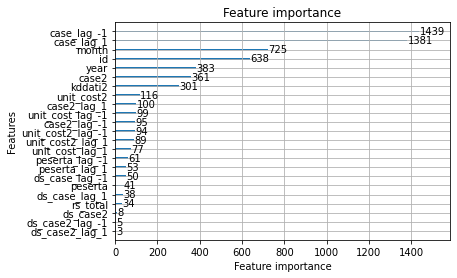

In [24]:
lgb.plot_importance(mdl)

#### Cost

Tidak jauh lebih baik dari baseline

In [25]:
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'mape',
              'metric': ['mape'], 
              'learning_rate': 0.2,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.95,
              'n_estimators': 1000,   
              'early_stopping_rounds': 100,
              'seed': SEED,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df2[['kddati2','tkp','unit_cost_lag_1','unit_cost_lag_-1','cat','id','unit_cost','row_id','tglpelayanan','kfold']],
        remove_additional_features=rs_features,
        kfold=fold,
        target=TARGET[1]
    )

['kddati2', 'tkp', 'unit_cost_lag_1', 'unit_cost_lag_-1', 'id']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's mape: 0.0432648	valid_1's mape: 0.0428055
MAPE CV-1 is 4.28%
MAE CV-1 is 86278.22
['kddati2', 'tkp', 'unit_cost_lag_1', 'unit_cost_lag_-1', 'id']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	training's mape: 0.0427262	valid_1's mape: 0.0493831
MAPE CV-2 is 4.94%
MAE CV-2 is 86490.30
['kddati2', 'tkp', 'unit_cost_lag_1', 'unit_cost_lag_-1', 'id']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.0421798	valid_1's mape: 0.0453531
MAPE CV-3 is 4.54%
MAE CV-3 is 87303.31
['kddati2', 'tkp', 'unit_cost_lag_1', 'unit_cost_lag_-1', 'id']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's mape: 0.0415888	valid_1's mape: 0.0470467
MAPE

Ganti metriks ke MAE

In [26]:
lgb_params = {'boosting_type': 'gbdt', 
              'objective': 'regression',
              'metric': ['mae'], 
              'learning_rate': 0.2,      
              'subsample': 0.9,       
              'subsample_freq': 1,     
              'num_leaves': 255,            
              'min_data_in_leaf': 255, 
              'feature_fraction': 0.95,
              'n_estimators': 1000,   
              'early_stopping_rounds': 100,
              'seed': SEED,
              'verbose': -1}
for fold in range(FOLD):
    mdl, val_df = process_train_lgb(
        df2[['kddati2','tkp','unit_cost_lag_1','unit_cost_lag_-1','cat','id','unit_cost','row_id','tglpelayanan','kfold']],
        remove_additional_features=rs_features,
        kfold=fold,
        target=TARGET[1]
    )

['kddati2', 'tkp', 'unit_cost_lag_1', 'unit_cost_lag_-1', 'id']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	training's l1: 75113.1	valid_1's l1: 78509.7
MAPE CV-1 is 4.41%
MAE CV-1 is 78509.73
['kddati2', 'tkp', 'unit_cost_lag_1', 'unit_cost_lag_-1', 'id']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	training's l1: 75372.9	valid_1's l1: 80356.7
MAPE CV-2 is 5.18%
MAE CV-2 is 80356.66
['kddati2', 'tkp', 'unit_cost_lag_1', 'unit_cost_lag_-1', 'id']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	training's l1: 74271.3	valid_1's l1: 81091
MAPE CV-3 is 4.55%
MAE CV-3 is 81091.00
['kddati2', 'tkp', 'unit_cost_lag_1', 'unit_cost_lag_-1', 'id']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	training's l1: 75015.1	valid_1's l1: 81682.3
MAPE CV-4 is 4.79%
MAE CV-4 is 81682.3